# Siggi Example

### Import necessary code from repo

In [1]:
import sys
sys.path.append('..')

In [2]:
from siggi import siggi, filters, spectra, calcIG, plotting
from siggi import Sed
from siggi.lsst_utils import BandpassDict
import matplotlib.pyplot as plt
import numpy as np
%load_ext autoreload
%autoreload 2
%matplotlib inline

### Set up filter object and get example spectra

In [3]:
f = filters()
s = spectra()
red_spec = s.get_red_spectrum()
blue_spec = s.get_blue_spectrum()

### Define redshift prior

In [4]:
def prior_z(z, z0=0.5):
    return (z**2.)*np.exp(-(z/z0)**1.5)/(np.sum((np.arange(0, 2.51, .05)**2.)*np.exp(-(np.arange(0, 2.51, .05)/z0)**1.5)))

In [5]:
# Shows the total entropy for 2 SEDs with equal weighting
entropy = -1. * .5 * np.sum(prior_z(np.arange(0.05, 2.51, .05)) * np.log2(.5 * prior_z(np.arange(0.05, 2.51, .05))))
print(entropy*2.)

5.807147751224095


### Set up a siggi object with the SEDs, the SED weights, the prior, and the redshift binning defined.

In [6]:
sig_example = siggi([red_spec, blue_spec], [0.5, 0.5], prior_z,
                    z_min=0.05, z_max=2.5, z_steps=50)

### Can also include a set of filters that are static and not moved in the optimization

Here we use the LSST *ugrizy* filters

In [7]:
frozen_dict = BandpassDict.loadTotalBandpassesFromFiles(bandpassDir='../data/lsst_baseline_throughputs/')

### Run optimization

In [8]:
%%time
num_filters = 2
res = sig_example.optimize_filters(num_filters=num_filters,
                                   filt_min=300., filt_max=1100., default_width=45., default_ratio=1.0, 
                                   sed_mags=19.0,
                                   adjust_widths=True, width_min=15., width_max=150.,
                                   adjust_width_ratio=False, ratio_min=0.25, ratio_max=0.75,
                                   system_wavelen_max=1200.,
                                   n_opt_points=10, adjust_independently=True,
                                   optimizer_verbosity=5,
                                   procs=2, acq_func_kwargs_dict={'kappa':3},
                                   frozen_filt_dict=frozen_dict, frozen_filt_eff_wavelen=[365, 477, 622, 765, 870, 1015],
                                   starting_points = [[150.0, 150.0, 375.0, 700.0],
                                                      [75.0, 75.0, 375.0, 1025.0],
                                                      [150.0, 150.0, 375.0, 1025.0],
                                                      [75.0, 75.0, 375.0, 700.0]])

[(15.0, 150.0), (15.0, 150.0), (300.0, 1100.0), (300.0, 1100.0)]
[150.0, 150.0, 375.0, 700.0] 5.804660027777407
[75.0, 75.0, 375.0, 1025.0] 5.803338166247112


[Parallel(n_jobs=2)]: Done   2 out of   4 | elapsed:   26.5s remaining:   26.5s


[75.0, 75.0, 375.0, 700.0] 5.804980915160632
[150.0, 150.0, 375.0, 1025.0] 5.803111202453389


[Parallel(n_jobs=2)]: Done   4 out of   4 | elapsed:   53.1s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   4 out of   4 | elapsed:   53.1s finished


-5.804980915160632 4
[18.51422734251628, 59.40360102406109, 506.8624305010416, 1029.0300326603533] 5.802431935789266
[119.71515843996863, 46.006678182355685, 411.3264987752207, 814.7063330709739] 5.8037356357316465


[Parallel(n_jobs=2)]: Done   2 out of   4 | elapsed:   34.2s remaining:   34.2s


[86.78698305230124, 92.39137845327285, 576.578132574316, 1041.1709791329704] 5.805625295348846


[Parallel(n_jobs=2)]: Done   4 out of   4 | elapsed:   55.4s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   4 out of   4 | elapsed:   55.4s finished


-5.805625295348846 7
[138.2456390398704, 105.51172879750757, 599.5977803976784, 890.0893025878574] 5.8026449445172235
[46.257530098460634, 39.19844156666542, 443.7567135817869, 901.5723846413733] 5.803526065623519


[Parallel(n_jobs=2)]: Done   2 out of   4 | elapsed:   27.4s remaining:   27.4s


[95.47310799490893, 90.0844399427209, 472.0004814616178, 715.5329760061732] 5.805359793312978


[Parallel(n_jobs=2)]: Done   4 out of   4 | elapsed:   47.8s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   4 out of   4 | elapsed:   47.8s finished


-5.805625295348846 10
CPU times: user 3.34 s, sys: 366 ms, total: 3.7 s
Wall time: 2min 39s


### Find the best results

In [9]:
min_idx = np.argmin(res.yi)

In [10]:
best_pt = res.Xi[min_idx]

In [11]:
best_val = np.min(res.yi)

In [12]:
print(best_pt, best_val)

[86.78698305230124, 92.39137845327285, 576.578132574316, 1041.1709791329704] -5.805625295348846


### Plot with Siggi's plotting code

In [13]:
red_spec.redshiftSED(0.5)
blue_spec.redshiftSED(0.5)
sig_plot = plotting([red_spec, blue_spec], best_pt[2:], best_pt[:2], 1.0,
                    frozen_filt_dict=frozen_dict, frozen_filt_eff_wavelen=[365, 477, 622, 765, 870, 1015],
                    sed_mags=19.0)

#### Let's first make a plot of the new filters along with the filters we've frozen in place. For reference we'll also include the SEDs at redshift z=0.5.

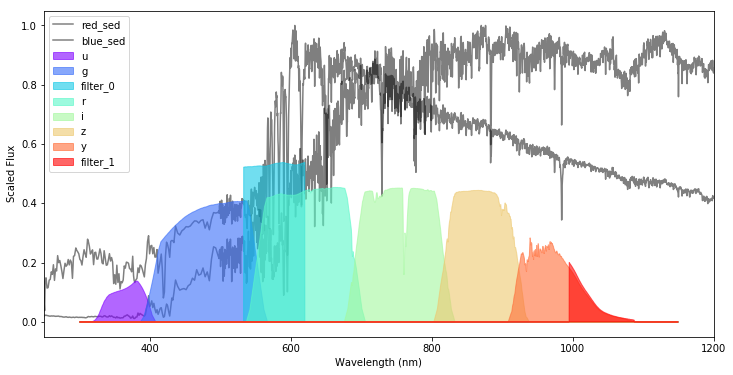

In [14]:
fig = sig_plot.plot_filters()
plt.legend(['red_sed', 'blue_sed'] + sig_plot.filter_dict.keys())

#### We can also look at a color-color plot of the new color values for each sed as it increases in redshift and the error bars on the colors

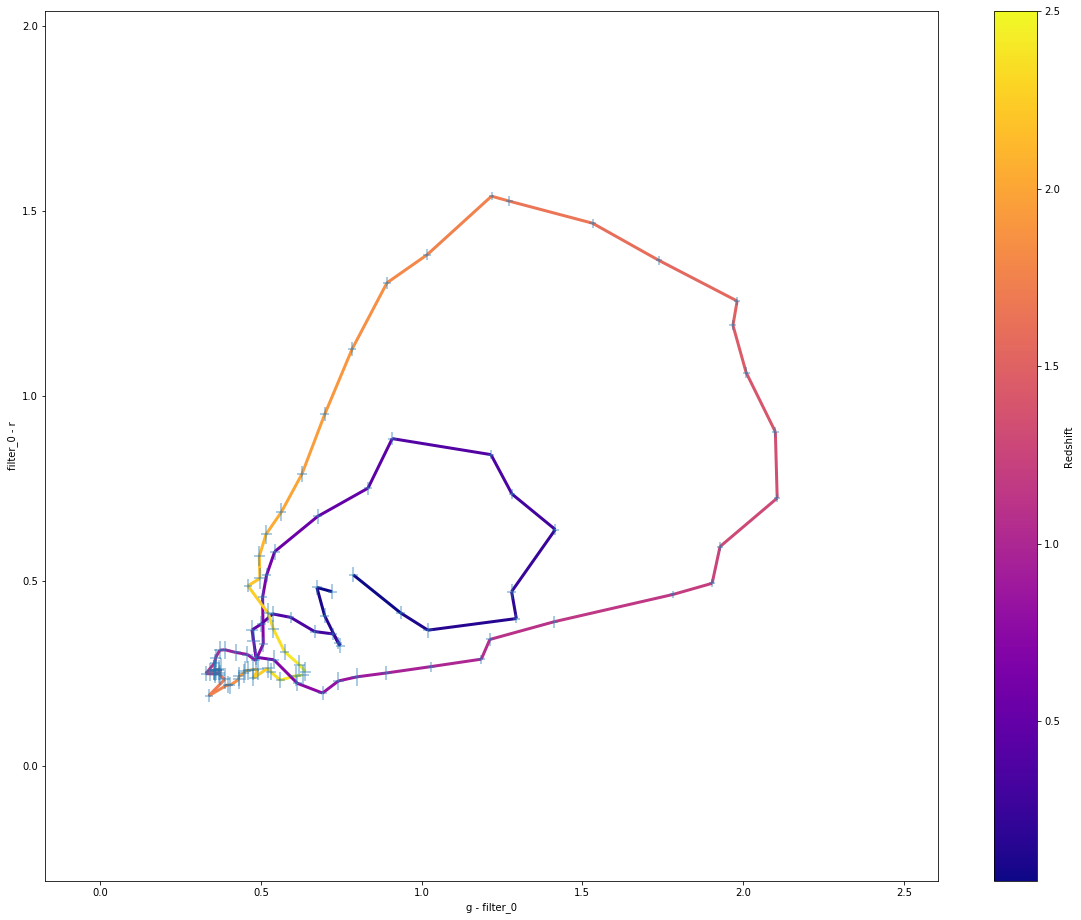

In [17]:
fig = plt.figure(figsize=(20,16))
fig = sig_plot.plot_color_color(['g', 'filter_0', 'filter_0', 'r'],
                                np.linspace(0.05, 2.5, 50), fig=fig)